# RAG Based on RAG-Fusion
- Hybrid Search
- ReRanker
- RAG-Fusion

## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Bedrock Client 생성

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models())

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-Embeddings-V2': 'amazon.titan-embed-text-v2:0',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Expres

## 2. Titan Embedding 및 LLM 인 Claude-v3 모델 로딩

### LLM 로딩 (Claude-v3)

In [5]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
    },
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f4d30237bb0>], client=<botocore.client.BedrockRuntime object at 0x7f4d03fddbd0>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True)

### Embedding 모델 선택

In [7]:
from utils.rag import KoSimCSERobertaContentHandler, SagemakerEndpointEmbeddingsJumpStart

교육목표 설정 방법
교육목표 수립 시 고려사항

===== RAG-Fusion Queries =====
['교육목표는?', '교육목표 설정 방법', '교육목표 수립 시 고려사항']
교육 목표 설정
교육 목표의 중요성

===== RAG-Fusion Queries =====
['교육목표는?', '교육 목표 설정', '교육 목표의 중요성']
교육목표 설정 방법
교육과정 설계 시 고려사항

===== RAG-Fusion Queries =====
['교육목표는?', '교육목표 설정 방법', '교육과정 설계 시 고려사항']


In [8]:
def get_embedding_model(is_bedrock_embeddings, is_KoSimCSERobert, aws_region, endpont_name=None):
    
    if is_bedrock_embeddings:
        # We will be using the Titan Embeddings Model to generate our Embeddings.
        from langchain.embeddings import BedrockEmbeddings
        llm_emb = BedrockEmbeddings(
            client=boto3_bedrock,
            model_id=bedrock_info.get_model_id(
                model_name="Titan-Embeddings-G1"
            )
        )
        print("Bedrock Embeddings Model Loaded")

    elif is_KoSimCSERobert:
        LLMEmbHandler = KoSimCSERobertaContentHandler()
        endpoint_name_emb = endpont_name
        llm_emb = SagemakerEndpointEmbeddingsJumpStart(
            endpoint_name=endpoint_name_emb,
            region_name=aws_region,
            content_handler=LLMEmbHandler,
        )        
        print("KoSimCSERobert Embeddings Model Loaded")
    else:
        llm_emb = None
        print("No Embedding Model Selected")
    
    return llm_emb

#### [중요] is_KoSimCSERobert == True 일시에 endpoint_name 을 꼭 넣어 주세요.

In [9]:
is_bedrock_embeddings = True
is_KoSimCSERobert = False
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

##############################
# Parameters for is_KoSimCSERobert
##############################
if is_KoSimCSERobert: endpont_name = "<endpoint-name>"
else: endpont_name = None
##############################

llm_emb = get_embedding_model(is_bedrock_embeddings, is_KoSimCSERobert, aws_region, endpont_name)   

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [10]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [11]:
depoly = False

In [12]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [13]:
import boto3
from utils.ssm import parameter_store

In [14]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [15]:
pm.put_params(
    key="reranker_endpoint",
    value=f'{predictor.endpoint}',
    overwrite=True,
    enc=False
)

NameError: name 'predictor' is not defined

## 4. Invocation (prediction)

In [16]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7ff1455eb310>


In [17]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [18]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [19]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9987371563911438}, {'label': 'LABEL_0', 'score': 0.0028581616934388876}]
CPU times: user 13.6 ms, sys: 296 µs, total: 13.9 ms
Wall time: 99.7 ms


## 5. LangChainmOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [20]:
import boto3
from utils.ssm import parameter_store

In [21]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [22]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [23]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [24]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: summit-workshop-index


### OpenSearch Client 생성

In [25]:
from utils.opensearch import opensearch_utils

In [26]:
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 6. Retriever based on Hybrid Search + RAG-Fusion + ReRanker
- LangChain에서 제공하는 **BaseRetriever** 클래스를 상속받아 **Custom Retriever**를 정의 할 수 있습니다.
- Hybrid-Search에 대한 자세한 내용는 **"01_rag_hybrid_search.ipyno"** 에서 확인 가능합니다.
- [RAG-Fusion](https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1)
![rag-fusion.png](../../../imgs/rag-fusion.png)

In [27]:
from utils.rag import OpenSearchHybridSearchRetriever

- 필터 설정 예시
- filter=[ <BR>
    　{"term": {"metadata.[**your_metadata_attribute_name**]": "**your first keyword**"}}, <BR>
    　{"term": {"metadata.[**your_metadata_attribute_name**]": "**your second keyword**"}},<BR>
]

In [33]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    # necessary
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in rag_fusion
    llm_emb=llm_emb,

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.5, .5], # [for lexical, for semantic], Lexical, Semantic search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    rag_fusion=True, # enable rag_fusion
    query_augmentation_size=3, # query_augmentation_size in rag_fusion

    # option for async search
    async_mode=False,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=True
)

### Retrieval example
- default search

In [34]:
from utils.rag import show_context_used

In [38]:
query = "중지된 경우 이체"

교육 목표 정의
효과적인 교육 목표 수립 방법
학생 중심 교육 목표 설정 전략

===== RAG-Fusion Queries =====
['교육목표는?', '교육 목표 정의', '효과적인 교육 목표 수립 방법', '학생 중심 교육 목표 설정 전략']

[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

##############################
async_mode
##############################
False
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
True
##############################
HyDE
##############################
False
##############################
parent_document
##############################
False
##############################
complex_document
##############################
True
##############################
similar_docs_semantic
##############################

Score: 0.030658062397801205
['‧ 창의적 체험활동의 영역별 활동내용, 평가방법 및

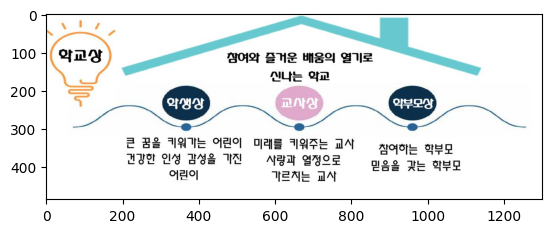

이 이미지는 학교생활에서 일어날 수 있는 세 가지 역할 즉, 학생상, 교사상, 학부모상을 설명하고 있습니다. 각 역할이 수행해야 할 바람직한 행동들을 열거하고 있으며, 궁극적으로
이 세 가지 역할이 잘 어우러져 좋은 배움의 열매를 맺는 것이 목표라는 것을 보여줍니다.
metadata:
 {'img_path': './fig/figure-3-21.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'f7042aaf-9bae-4135-a374-7dc78b666c05', 'origin_image': ''}
CPU times: user 626 ms, sys: 141 ms, total: 768 ms
Wall time: 2.23 s


In [36]:
%%time
search_hybrid_result = opensearch_hybrid_retriever.get_relevant_documents(query)

print("\n==========  Results  ==========\n")
print(f'1. question: {query}')
print (f'2. # documents: {len(search_hybrid_result)}')
print("3. Documents: \n")

show_context_used(search_hybrid_result)

- update parameters

In [40]:
opensearch_hybrid_retriever.update_search_params(
    k=10,
    minimum_should_match=30,
    filter=[
        #{"term": {"metadata.project": "KS"}},
    ],
    reranker=True,
    reranker_endpoint_name=endpoint_name,
    rag_fusion=True, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    llm_text=llm_text, # llm for query augmentation in rag_fusion
    verbose=False
)

교육목표 설정 방법
효과적인 교육목표 설정 전략
==========  Results  ==========

1. question: 교육목표는?
2. # documents: 3
3. Documents: 


-----------------------------------------------
1. Category: Table, Chunk: 155 Characters
-----------------------------------------------
이 표는 어린이 교육의 세 가지 주요 목표를 제시하고 있습니다. 첫째, 존중과 나눔을 실천하는 바른 인성을 기르는 것입니다. 둘째, 몸과 마음의 건강 및 예술 향유를 통해 문화적
소양을 기르는 것입니다. 셋째, 특기와 소질 계발을 통해 미래를 대비하는 창의성을 기르는 것입니다.
metadata:
 {'source': './data/complex_pdf/school_edu_guide.pdf', 'detection_class_prob': 0.5580280423164368,
'coordinates': {'points': [[161.56983947753906, 716.003173828125], [161.56983947753906,
966.0720825195312], [1475.974853515625, 966.0720825195312], [1475.974853515625, 716.003173828125]],
'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2337}, 'last_modified':
'2024-04-04T01:39:24', 'text_as_html': '<table><tr><td>K 뼈 4</td><td>특 기 와 소 질 을 가꾸어 미 래 를 준 비 하는
창의적인 어린이</td></tr></table>', 'filetype': 'application/pdf', 'languages': ['kor', 'eng'],
'page_number': 3, 'f

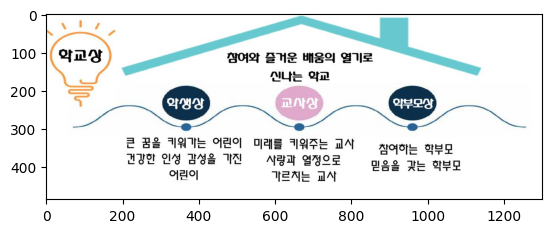

이 이미지는 학교생활에서 일어날 수 있는 세 가지 역할 즉, 학생상, 교사상, 학부모상을 설명하고 있습니다. 각 역할이 수행해야 할 바람직한 행동들을 열거하고 있으며, 궁극적으로
이 세 가지 역할이 잘 어우러져 좋은 배움의 열매를 맺는 것이 목표라는 것을 보여줍니다.
metadata:
 {'img_path': './fig/figure-3-21.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'f7042aaf-9bae-4135-a374-7dc78b666c05', 'origin_image': ''}

-----------------------------------------------
6. Category: CompositeElement, Chunk: 699 Characters
-----------------------------------------------
‧ 창의적 체험활동의 영역별 활동내용, 평가방법 및 기준은 교육과정을 근 - 9 - □5 선행교육 예방 (공교육정상화법) 교사 우○주 ❍ 선행교육 -「초‧중등교육법」제23조제2항에
따라 교육부장관이 정한 초․중등학교 교육과정(국가교육과정) 및 교육감이 정한 초․중등학교 교육과정(시․도교육과정), 「초‧중등교육법」제23조제1항에 근거하여 편성․운영되는 단위학교
교육과정(학교 교육과정) 국가교육과정-시․도교육과정-학교 교육과정에 앞서서 편성 또는 제공하는 교육 일반 ❍ 선행학습 - 학습자가 국가교육과정, 시․도교육과정, 학교 교육과정에
앞서서 하는 학습 1. 추진 근거 및 목적 L RIS 가. 근거 Ÿ 「공교육 정상화 촉진 및 선행교육 규제에 관한 특별법」(공교육정상화법) Ÿ 2024년 선행학습 유발 관행 근절
사업 추진계획(교육부 기초학력진로교육과-379, 2024.1.31.) = [9 = < [aN] & - % 5 = 해 때 R 제 0 | 버 과 E 제 o 99 = = B

In [41]:
query = "중지된 경우 이체"
search_hybrid_result = opensearch_hybrid_retriever.get_relevant_documents(query)

print("\n==========  Results  ==========\n")
print(f'1. question: {query}')
print(f'2. # documents: {len(search_hybrid_result)}')
print("3. Documents: \n")

show_context_used(search_hybrid_result)

## 5. RAG using RetrievalQA powered by LangChain

In [42]:
from utils.rag import prompt_repo

### Prompting
- [TIP] Prompt의 instruction의 경우 한글보다 영어로 했을 때 더 좋은 결과를 얻을 수 있습니다.

In [43]:
system_prompt = prompt_repo.get_system_prompt()
pprint (system_prompt)

('\n'
 '                        You are a master answer bot designed to answer '
 "user's questions.\n"
 "                        I'm going to give you contexts which consist of "
 'texts, tables and images.\n'
 "                        Read the contexts carefully, because I'm going to "
 'ask you a question about it.\n'
 '                        ')


### Update Search Params (Optional)

In [44]:
from utils.rag import qa_chain
from langchain.schema.output_parser import StrOutputParser

In [53]:
opensearch_hybrid_retriever.update_search_params(
    k=5,
    minimum_should_match=0,
    filter=[],
    reranker=True,
    reranker_endpoint_name=endpoint_name,
    rag_fusion=True, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    llm_text=llm_text, # llm for query augmentation in rag_fusion
    
    # option for complex documents consisting of text, table and image
    complex_doc=False, # False 이면, invocation시 text만 넣는다.
    
    async_mode=True,
    verbose=True
)

### Request

In [54]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

In [55]:
query = "중지된 경우 이체"
query = "교육목표는?"
#query = "vidio max size?"
#query = "수익률 그래프를 설명해줘"
response, contexts = qa.invoke(
    query = query
)

show_context_used(contexts)


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

##############################
async_mode
##############################
True
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
True
##############################
HyDE
##############################
False
##############################
parent_document
##############################
False
##############################
complex_document
##############################
False
##############################
similar_docs_semantic
##############################

Score: 0.03150322646290388
['‧ 창의적 체험활동의 영역별 활동내용, 평가방법 및 기준은 교육과정을 근 - 9 - □5 선행교육 예방 (공교육정상화법) 교사 우○주 ❍ 선행교육 -「초‧중등교육법」제23조제2항에 따라 교육부장관이 정한 초․중등학교 교육과정(국가교육과정) 및 교육감이 정한 초․중등학교 교육과정(시․도교육과정), 「초‧

In [56]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)

print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts)

##################################
query:  교육목표는?
##################################


### Answer ###
상록 교육 목표는 "바른 인성, 건강한 감성, 즐거운 배움으로 미래를 가꾸는 어린이"라고 명시되어 있습니다.


### Contexts ###

-----------------------------------------------
1. Category: CompositeElement, Chunk: 647 Characters
-----------------------------------------------
2024학년도 학 교 교 육 과 정 설 명 회 연 수 자 료 일시: 2024년 3월 20일 (수) 바른 인성, 건강한 감성, 즐거운 배움으로 미래를 가꾸는 바른 인성, 건강한
감성, 즐거운 배움으로 미래를 가꾸는 학부모 연수 순서 학부모 연수 순서 1. 상록 교육목표 및 구현계획 2. 2024학년도 학사 일정 안내 3. 출결 관련 확인 제출자료 안내
4. 학교교육평가 5. 선행교육 예방(공교육정상화법) 6. 학생 안전 교육 7. 성폭력 예방 교육 8. 흡연 및 음주 예방 교육 9. 학생 인권조례 및 교권보호 10. 방과후학교
운영 11. 초등돌봄교실(오후돌봄) 운영 12. 학부모 서비스 신청 안내 13. 정보통신윤리교육 14. 정보보안 및 개인정보보호 운영 계획 15. 불법찬조금 근절 16. 아동학대
예방 교육 17. 가정폭력 예방 교육 18. 생명 존중 및 생명 살림(자살 예방) 교육 19. 교육활동 참여자 안전교육(녹색, 학부모폴리스) 20. 학교폭력 예방 교육 21.
감염병 예방 교육 22. 청탁금지법 23. 공익제보자 보호 및 공익 신고 보상 안내 24. 존중과 배려의 교육환경 조성 예방 교육(갑질 근절) 25. 교육활동보호예방교육 1 상록
교육 목표 및 구현 계획 비전 바른 인성, 건강한 감성, 즐거운 배움으로 미래를 가꾸는 어린이
metadata:
 {'source'